link huggingface: https://huggingface.co/spaces/edwinrdrr/P2M1

# 1. Perkenalan

## Perkenalan Diri

Nama : Edwin Reyhan Devara Ramadhan Rasya  
Batch : FTDS-017-RMT

## Objective

Perusahaan kita adalah perusahaan yang bergerak pada bidang E-commerce. Perusahaan kita mengalami kerugian yang lumayan besar karena customer kita banyak yang churn. Maka dari itu, perusahaan kita ingin meminimalkan kemungkinan customer kita untuk churn dan meminta kita data scienstist untuk melakukan hal itu.  

Pertama kita akan menganalisa faktor apa saja yang dapat membuat customer kita churn. Dari situ kita sebenarnya sudah bisa melakukan antisipasi customer yang akan churn. Namun, untuk mempermudah menentukan siapa saja customer kita yang akan churn, kita akan membangun sebuah model deep learning menggunakan sequential dan functional.  

Lalu syaratnya apa saja agar model yang kita bangun dapat digunakan pada day-to-day business untuk menentukan apakah customer akan churn atau tidak?  

1. Model kita harus dapat memprediksi customer kita yang beneran churn sebagai customer churn (jumlah True Positive tinggi)

2. Maka dari itu, kita tidak ingin ada customers yang sebenarnya churn tapi model kita salah prediksi bahwa mereka tidak churn, yang mana hal ini dapat merugikan perusahaan kita karena customers yang churn tidak terdeteksi. (jumlah False Negative rendah) (Recall score yang tinggi)

3. Kita dapat memberikan diskon, gift, dll kepada customer yang akan churn untuk membuat mereka membatalkan niat untuk churn.

4. Namun, kita juga tidak mau salah kirim diskon, gift, dll kepada banyak customer yang tidak risiko untuk churn, yang mana dapat merugikan kita juga karena sebenarnya customer yang tidak churn ini tidak membutuhkan diskon, gift, dll. Hal ini bisa disebabkan oleh model kita salah prediksi customer yang tidak churn sebagai customer yang churn, yang mana berarti kita ingin kasus salah prediksi ini tidak terlalu besar. (jumlah False Positive tidak terlalu banyak) (precision tidak terlalu kecil)  


Fokus metric : False Negative atau Recall Score dengan ditemani oleh Precision Score yang tidak terlalu kecil.

# 2. Importing the Libraries

In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import pickle
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras import Model 

# 3. Data Loading

In [ ]:
# loading the data
data_raw = pd.read_csv('/content/drive/MyDrive/H8/google_colab/P2M1/churn.txt')
data_raw.head()

,user_id,age,gender,region_category,membership_category,joining_date,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,9f420209e7d129f3,29,F,NaN,No Membership,2017-04-05,Yes,Without Offers,NaN,Wi-Fi,...,1184.49,38604.69,10.0,627.48,Yes,Yes,Yes,No Information Available,Poor Website,1
1,ac6e97806267549e,50,M,NaN,Basic Membership,2017-03-31,Yes,Without Offers,Desktop,Fiber_Optic,...,338.15,7665.66,17.0,575.97,Yes,No,Yes,No Information Available,Poor Customer Service,1
2,a6aa19b1580eed4e,26,F,City,Silver Membership,2017-02-11,NaN,Credit/Debit Card Offers,NaN,Fiber_Optic,...,235.14,37671.69,5.0,767.93,Yes,No,Yes,No Information Available,Too many ads,0
3,aeee343277211c2f,63,F,Village,No Membership,2015-12-23,No,Credit/Debit Card Offers,Desktop,Fiber_Optic,...,56.67,15678.14,11.0,590.22,No,Yes,No,Not Applicable,Too many ads,1
4,82448b5c8ce6390c,64,M,Town,Silver Membership,2015-03-20,NaN,Gift Vouchers/Coupons,Smartphone,Wi-Fi,...,153.99,8422.68,0.0,722.04,Yes,No,No,Not Applicable,Poor Product Quality,0


# 4. EDA

In [ ]:
# copying the data for eda purpose only
data_eda = data_raw.copy()

## Check numerical and categorical features

In [ ]:
# Which features that are already in numerical format
data_eda.select_dtypes(include=np.number).head(2)

,age,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,churn_risk_score
0,29,4,1184.49,38604.69,10.0,627.48,1
1,50,11,338.15,7665.66,17.0,575.97,1


Discrete Features (Feature yang nilainya dapat dihitung bulat):  
'age', 'days_since_last_login'    

Continuous Features (Feature yang nilainya sangat detail dengan angka yang lebih spesifik di belakang koma):  
'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days',	'points_in_wallet'  

Numerical Features that are encoded (binary yes/no, nilainya mempunyai level namun tidak bisa ditambah maupun dikurang, tapi nilai feature ini sudah berbentuk angka):  
'churn_risk_score' --> target column

In [ ]:
# Which features that are still in categorical format
data_eda.select_dtypes(include='object').head(2)

,user_id,gender,region_category,membership_category,joining_date,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback
0,9f420209e7d129f3,F,NaN,No Membership,2017-04-05,Yes,Without Offers,NaN,Wi-Fi,22:29:49,Yes,Yes,Yes,No Information Available,Poor Website
1,ac6e97806267549e,M,NaN,Basic Membership,2017-03-31,Yes,Without Offers,Desktop,Fiber_Optic,15:44:56,Yes,No,Yes,No Information Available,Poor Customer Service


Nominal category (Nilai yang tidak punya level):  
'user_id', 'gender', 'region_category', 'joined_through_referral', 'preferred_offer_types', 'medium_of_operation', 'internet_option', 'used_special_discount', 'offer_application_preference', 'past_complaint', 'complaint_status', 'feedback'  

Ordinal category (Nilai yang punya level):  
'membership_category'  

Data or Time:  
'joining_date', 'last_visit_time'

## Visualize Discrete Features

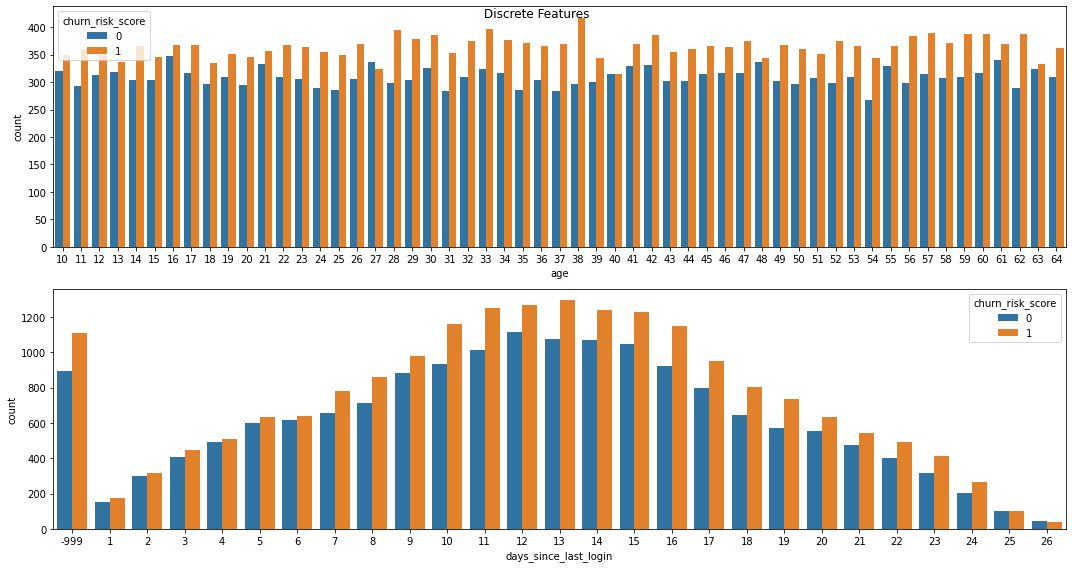

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8))
fig.suptitle('Discrete Features')

sns.countplot(ax=axes[0], data=data_eda, x='age', hue='churn_risk_score')
sns.countplot(ax=axes[1], data=data_eda, x='days_since_last_login', hue='churn_risk_score')

fig.tight_layout();

Feature age tidak dapat melakukan klasifikasi customer ke yang akan churn dan tidak churn. Semakin tua customer atau semakin muda customer tidak dapat menunjukkan customer tersebut akan churn atau tidak.

Berapa hari customer terakhir login juga tidak dapat melakukan klasifikasi customer ke yang akan churn atau tidak churn. Walaupun pada grafik hari 25 dan 26 ada perubahan trend, namun hal ini tidak signifikan sama sekali.

## Visualize Continuous Features

In [ ]:
num_cont = ['avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days', 'points_in_wallet']

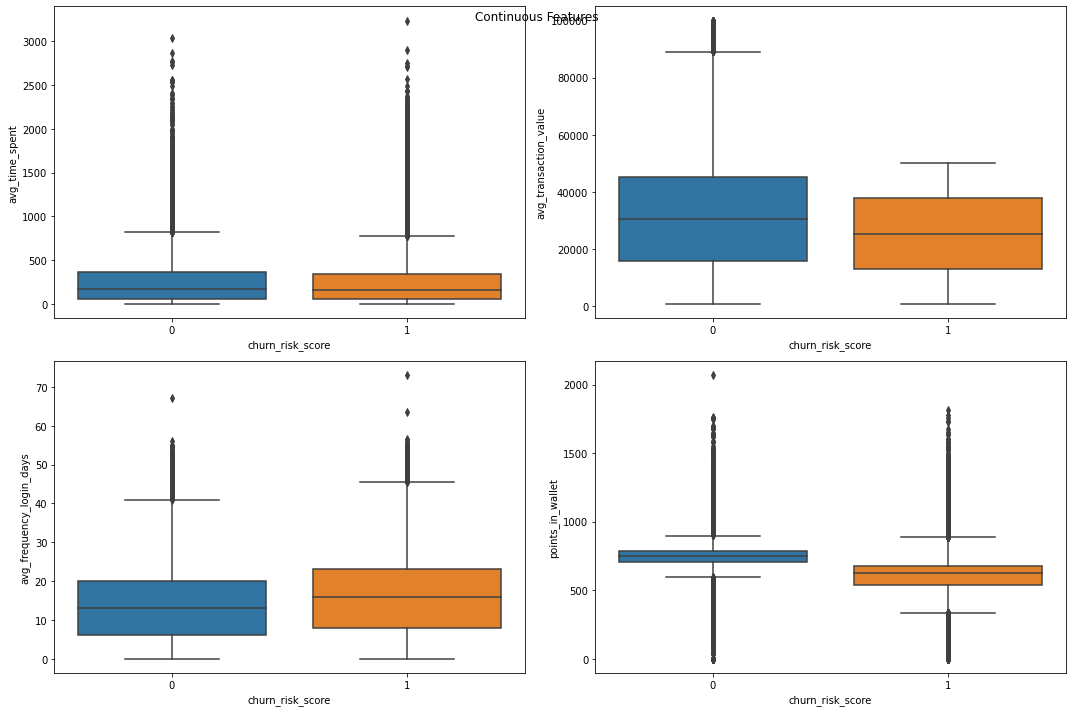

In [ ]:
# melakukan visualisasi continuous numerical 
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Continuous Features')

for i, x in zip(range(0,2),range(0,2)):
    sns.boxplot(ax=axes[0,i], data=data_eda, x='churn_risk_score', y=num_cont[x])

for i, x in zip(range(0,2),range(2,4)):
    sns.boxplot(ax=axes[1,i], data=data_eda, x='churn_risk_score', y=num_cont[x])

fig.tight_layout();

Rata-rata waktu yang dihabiskan customer di website kita tidak dapat melakukan klasifikasi customer ke yang akan churn atau tidak churn. Customer yang churn dan tidak churn tidak memiliki perbedaan rata-rata waktu yang dihabiskan di website.

Jumlah uang yang pernah ditransaksikan oleh customer ke kita dapat melakukan klasifikasi customer ke yang churn dan tidak churn. Mereka yang tidak churn sudah menghabiskan uang lebih besar dibandingkan mereka yang churn.  

Mereka yang tidak churn juga memiliki points yang lebih besar dibandingkan mereka yang churn. Maka dari itu informasi ini juga dapat melakukan klasifikasi customer kita ke yang churn dan tidak.  

Sedangkan berdasarkan frekuensi login webstite yang customer lakukan, customer yang churn lebih banyak melakukan login ke website dibandingkan customer kita yang tidak churn.  
Hal ini mungkin disebabkan oleh customers yang churn ini berhenti memakai produk kita karena mereka tidak suka dengan tampilan website kita, atau layanan website kita. Hal ini perlu dianalisis secara terpisah.  
Maka dari itu, informasi berapa sering customer kita login ke website dapat melakukan klasifikasi customer ke yang akan churn dan tidak churn.

## Visualize Nominal Features

In [ ]:
cat_nom = ['gender', 'region_category', 'joined_through_referral', 'preferred_offer_types', 'medium_of_operation', 'internet_option', 'used_special_discount', 'offer_application_preference', 'past_complaint']
cat_nom_separate = ['complaint_status', 'feedback']

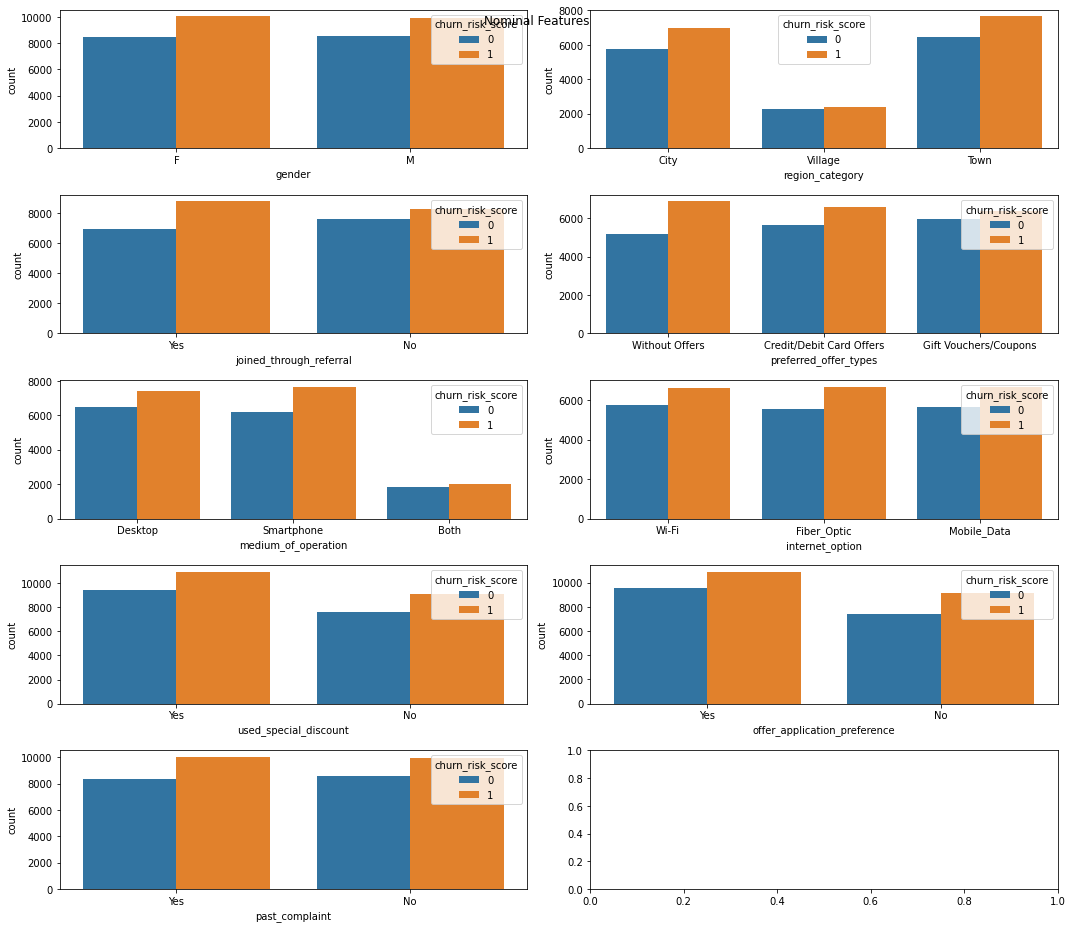

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(15, 13))
fig.suptitle('Nominal Features')


for i, x in zip(range(0,2),range(0,2)):
    sns.countplot(ax=axes[0,i], data=data_eda, x=cat_nom[x], hue='churn_risk_score')

for i, x in zip(range(0,2),range(2,4)):
    sns.countplot(ax=axes[1,i], data=data_eda, x=cat_nom[x], hue='churn_risk_score')
    
for i, x in zip(range(0,2),range(4,6)):
    sns.countplot(ax=axes[2,i], data=data_eda, x=cat_nom[x], hue='churn_risk_score')

for i, x in zip(range(0,2),range(6,8)):
    sns.countplot(ax=axes[3,i], data=data_eda, x=cat_nom[x], hue='churn_risk_score')

for i, x in zip(range(0,2),range(8,9)):
    sns.countplot(ax=axes[4,i], data=data_eda, x=cat_nom[x], hue='churn_risk_score')

fig.tight_layout()

Infomasi mengenai jenis kelamin, kategori tempat tinggal, device yang dipakai untuk membuka website atau melakukan transaksi, internet yang dipakai, join website kita pakai referral atau tidak, penawaran yang mereka suka, memakai diskon atau tidak, apakah mereka suka penawaran atau tidak, dan apakah mereka pernah melakukan komplain tidak memiliki perubahan atau perbedaan trend di setiap kategori pada 9 informasi ini.   
Maka dari itu, 9 informasi di atas dapat dikatakan tidak bisa melakukan klasifikasi customer kita ke customer churn atau tidak churn.

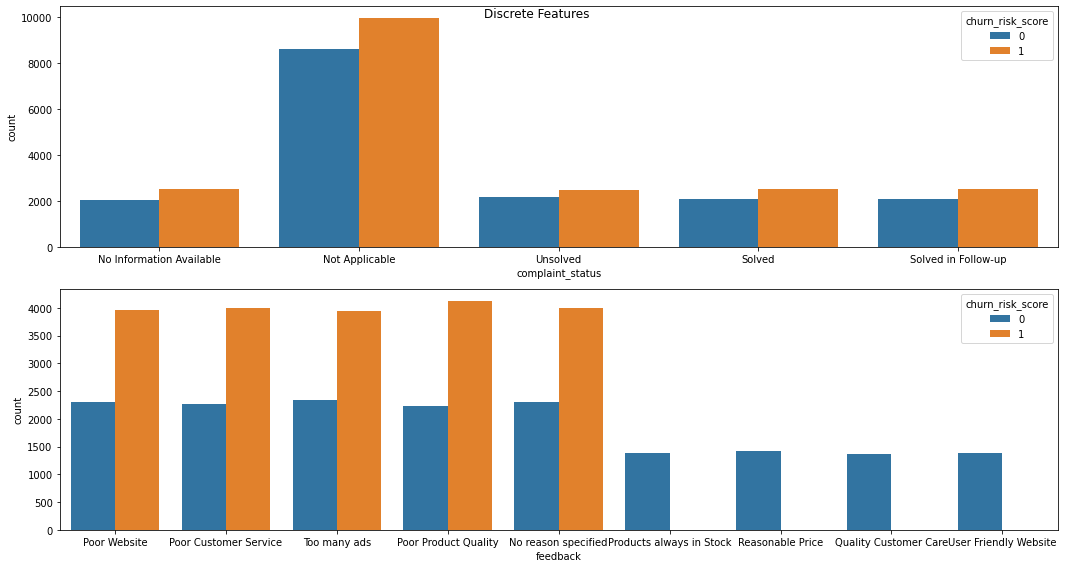

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8))
fig.suptitle('Discrete Features')

sns.countplot(ax=axes[0], data=data_eda, x=cat_nom_separate[0], hue='churn_risk_score')
sns.countplot(ax=axes[1], data=data_eda, x=cat_nom_separate[1], hue='churn_risk_score')

fig.tight_layout();

Tidak ada perbedaan atau perubahan trend pada setiap kategori informasi mengenai apakah komplain customer sudah kita selesaikan atau belum. Hal ini menunjukkan bahwa apakah komplain sudah kita selesaikan atau belum tidak tidak membedakan jenis customer kita, baik terselesaikan maupun belum customer yang churn masih lebih banyak dibandingkan customer yang tidak churn pada setiap kategori.  
Maka dari itu informasi apakah komplain customer sudah kita selesaikan atau belum dapat dikatakan bisa melakukan klasifikasi customer ke customer yang churn dan tidak churn.

Ketika customer memberikan feedback yang bagus, hal ini menunjukkan bahwa customer kita puas atau suka dengan layanan yang kita berikan.
Sedangkan jika customer kita memberikan feedback jelek, hal ini menunjukkan bahwa customer kita tidak puas atau tidak suka dengan layanan yang kita berikan, atau customers tersebut sangat terganggu oleh salah satu layanan kita yang membuat mereka churn.

Jika customers kita memberikan feedback bagus, kemungkinan mereka tetap memakai produk kita dan tidak churn sangat tinggi.
Sedangkan jika customers kita memberikan feedback jelek, kemungkinan mereka akan churn sangat besar.  

Maka dari itu, jenis feedback yang diberikan oleh customer, bagus atau jelek, dapat melakukan klasifikasi customer kita ke customer yang churn dan tidak churn.

## Visualize Ordinal Features

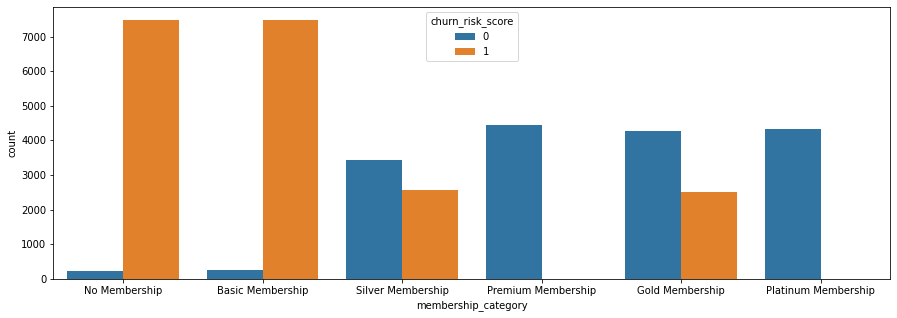

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
sns.countplot(ax=ax, data=data_eda, x=data_eda['membership_category'], hue='churn_risk_score');

Kebanyakan customers kita yang churn memiliki membership basic atau tidak punya sama sekali. Sedangkan customers yang tidak churn kebanyakan memiliki membership di atas basic. Walaupun beberapa customer yang churn juga memiliki membership di atas basic.  

Hal ini menunjukkan bahwa jenis membership yang customer punya dapat melakukan klasifikasi apakah customer tersebut kemungkinan akan churn atau tidak churn.

**Features yang dapat melakukan klasifikasi**:  
numerical features = 'avg_transaction_value', 'avg_frequency_login_days', 'points_in_wallet'  

categorical features = 'feedback', 'membership_category'

# 5. Feature Engineering

In [ ]:
# Copy the data for making ANN purpose only
data = data_raw.copy()

## Splitting the data

'complaint_status', 'feedback'

In [ ]:
# Split data to X and y
X = data.drop(['churn_risk_score','user_id','joining_date', 'last_visit_time'], axis=1)
y = data['churn_risk_score']

In [ ]:
# Split data to Training Set, Validation Set, and Testing Set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=0)

print('Training Set Shape : ', X_train.shape, y_train.shape)
print('Validation Set Shape : ', X_val.shape, y_val.shape)
print('Testing Set Shape : ', X_test.shape, y_test.shape)

Training Set Shape :  (26739, 18) (26739,)
Validation Set Shape :  (4719, 18) (4719,)
Testing Set Shape :  (5552, 18) (5552,)


## Handling Missing Values

In [ ]:
X_train.isnull().sum()

age                                0
gender                            42
region_category                 3929
membership_category                0
joined_through_referral         3886
preferred_offer_types            209
medium_of_operation             3906
internet_option                    0
days_since_last_login              0
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days           0
points_in_wallet                   0
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
dtype: int64

In [ ]:
np.round(X_train.isnull().sum() / len(X_train) * 100, 2)

age                              0.00
gender                           0.16
region_category                 14.69
membership_category              0.00
joined_through_referral         14.53
preferred_offer_types            0.78
medium_of_operation             14.61
internet_option                  0.00
days_since_last_login            0.00
avg_time_spent                   0.00
avg_transaction_value            0.00
avg_frequency_login_days         0.00
points_in_wallet                 0.00
used_special_discount            0.00
offer_application_preference     0.00
past_complaint                   0.00
complaint_status                 0.00
feedback                         0.00
dtype: float64

Kita akan mengubah missing value dari gender, region_category, joined_through_referral, preferred_offer_types, medium_of_operation menjadi other atau mode dari masing-masing feature di dalam pipeline

# 6. Pipeline

## Separating numerical and categorical features

In [ ]:
num_columns = X_train.select_dtypes(include=np.number).columns.tolist()

In [ ]:
cat_columns = X_train.select_dtypes(include='object').columns.tolist()

## Make pipelines to transform features

In [ ]:
cat_imputer = SimpleImputer(missing_values=np.NaN, strategy='constant', fill_value='other')

In [ ]:
# make numerical columns consist of scaler, and anova F-value to select the best features
pipe_num = Pipeline([
    ("scaler",StandardScaler()),
    ("f_classif",SelectKBest(f_classif, k = 3))
])

In [ ]:
pipe_cat = Pipeline([
    ('impute_other',cat_imputer),
    ("encode",OrdinalEncoder()),
    ("chi2",SelectKBest(chi2, k = 2))
])

Tiga numerical features dan dua categorical features adalah kombinasi yang memberikan score terbaik pada model.

In [ ]:
# menggabungkan pipe untuk categorical dan numerical beserta feature-featurenya
pipe_preprocessing_best = make_column_transformer(
    (pipe_num, num_columns),
    (pipe_cat, cat_columns)
)

In [ ]:
pipe_preprocessing_best.fit(X_train, y_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('f_classif',
                                                  SelectKBest(k=3))]),
                                 ['age', 'days_since_last_login',
                                  'avg_time_spent', 'avg_transaction_value',
                                  'avg_frequency_login_days',
                                  'points_in_wallet']),
                                ('pipeline-2',
                                 Pipeline(steps=[('impute_other',
                                                  SimpleImputer(fill_value='other',
                                                                strategy='constant')),
                                                 ('encode', OrdinalEncoder()),
                                                 ('chi2',
                                                  SelectKB

In [ ]:
# melakukan transform untuk data training
X_train_transformed = pipe_preprocessing_best.transform(X_train)

In [ ]:
# melakukan transform untuk data validation
X_val_transformed = pipe_preprocessing_best.transform(X_val)

In [ ]:
# melakukan transform untuk data testing
X_test_transformed = pipe_preprocessing_best.transform(X_test)

## Feature selection results

### Numerical Features

In [ ]:
# mendapatkan score masing-masing feature numerical
f_classif_scores = pipe_preprocessing_best.named_transformers_['pipeline-1']['f_classif'].scores_

In [ ]:
# melihat score masing-masing feature numerical
pd.DataFrame({'features': num_columns, 
              'scores':f_classif_scores}).sort_values('scores',ascending = False)

,features,scores
3,avg_transaction_value,1398.931618
5,points_in_wallet,1156.294325
4,avg_frequency_login_days,361.778555
2,avg_time_spent,7.363610
1,days_since_last_login,0.211116
0,age,0.000646


Karena kita hanya memilih tiga features dari numerical columns, maka dari itu hanya avg_transaction_value, points_in_wallet, dan avg_frequency_login_days yang akan kita masukkan ke model.

avg_transaction_value, points_in_wallet, dan avg_frequency_login_days memiliki score yang berbeda signifikan dengan yang tidak terpilih. Hal ini menunjukkan bahwa features avg_transaction_value, points_in_wallet, dan avg_frequency_login_days adalah features yang penting untuk melakukan klasifikasi customer ke customer yang churn dan tidak churn.

### Categorical Features

In [ ]:
# mendapatkan score masing-masing feature categorical
chi2_scores = pipe_preprocessing_best.named_transformers_['pipeline-2']['chi2'].scores_

In [ ]:
# melihat score masing-masing feature categorical
pd.DataFrame({'features': cat_columns, 
              'scores':chi2_scores}).sort_values('scores',ascending = False)

,features,scores
2,membership_category,7599.477262
11,feedback,2617.670153
3,joined_through_referral,15.035342
8,offer_application_preference,6.404258
4,preferred_offer_types,5.799438
5,medium_of_operation,3.735898
1,region_category,3.390593
9,past_complaint,1.652376
6,internet_option,1.140620
0,gender,0.782178


Karena kita hanya memilih dua feature dari sekian banyak categorical features, maka dari yang akan kita masukkan ke model hanya membership_category dan feedback.

Features membership_category dan feedback memiliki chi2 score yang sangat berbeda dengan features categorical yang lain. Hal ini membuktikan bahwa membership dan feedback adalah informasi atau features penting untuk melakukan klasifikasi customer ke customer yang churn dan tidak churn.

# Modeling

## Model 1

### Sequential

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model_1_seq = Sequential()
model_1_seq.add(Dense(80, activation='relu', input_shape=(5,)))
model_1_seq.add(Dense(80, activation='relu'))
model_1_seq.add(Dense(10, activation='relu'))
model_1_seq.add(Dense(1, activation='sigmoid'))

model_1_seq.compile(loss='binary_crossentropy', optimizer='Adam', metrics=[tf.keras.metrics.Recall()])

model_1_seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                480       
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 10)                810       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 7,781
Trainable params: 7,781
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
model_1_seq_history = model_1_seq.fit(X_train_transformed, y_train, epochs=30, validation_data=(X_val_transformed, y_val), batch_size=10, verbose=0)

CPU times: user 3min 11s, sys: 11 s, total: 3min 22s
Wall time: 3min 23s


In [ ]:
model_1_seq_history_df = pd.DataFrame(model_1_seq_history.history)
model_1_seq_history_df

,loss,recall,val_loss,val_recall
0,0.397370,0.829947,0.253793,0.909839
1,0.233827,0.919691,0.199048,0.938847
2,0.205703,0.929058,0.191705,0.907095
3,0.190635,0.935326,0.181465,0.960408
4,0.187341,0.938357,0.166743,0.946688
5,0.182112,0.940010,0.174881,0.929047
6,0.179707,0.939734,0.175521,0.981576
7,0.176908,0.940492,0.172439,0.959624
8,0.175713,0.939459,0.165685,0.947864
9,0.174005,0.942971,0.162744,0.952960


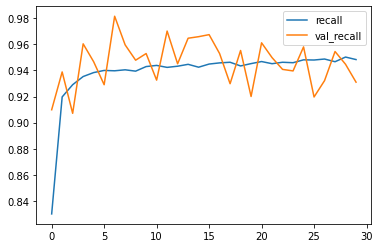

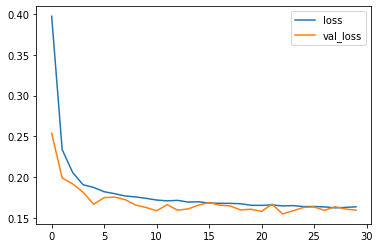

In [ ]:
model_1_seq_history_df[['recall', 'val_recall']].plot()
model_1_seq_history_df[['loss', 'val_loss']].plot();

In [ ]:
y_hat_1_seq = model_1_seq.predict(X_test_transformed)
y_hat_1_seq = np.where(y_hat_1_seq >= 0.5, 1, 0)

print(classification_report(y_test, y_hat_1_seq))

174/174 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      2604
           1       0.93      0.93      0.93      2948

    accuracy                           0.93      5552
   macro avg       0.93      0.93      0.93      5552
weighted avg       0.93      0.93      0.93      5552



### Functional

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

input_layer = Input(shape=(5,))
hiddenlayer_1 = Dense(30, activation='relu')(input_layer)
hiddenlayer_2 = Dense(30, activation='relu')(hiddenlayer_1)
output_layer = Dense(1, activation='sigmoid')(hiddenlayer_2)

model_1_func = Model(inputs=input_layer, outputs=output_layer)
model_1_func.compile(loss='binary_crossentropy', optimizer='Adam', metrics=[tf.keras.metrics.Recall()])

model_1_func.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense (Dense)               (None, 30)                180       
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1,141
Trainable params: 1,141
Non-trainable params: 0
_________________________________________________________________


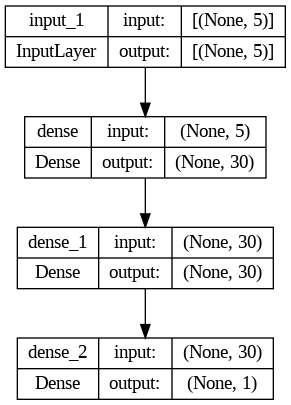

In [ ]:
tf.keras.utils.plot_model(model_1_func, show_shapes=True)

In [ ]:
%%time
model_1_func_history = model_1_func.fit(X_train_transformed, y_train, epochs=30, validation_data=(X_val_transformed, y_val), batch_size=10, verbose=0)

CPU times: user 3min, sys: 11 s, total: 3min 11s
Wall time: 3min 22s


In [ ]:
model_1_func_history_df = pd.DataFrame(model_1_func_history.history)
model_1_func_history_df

,loss,recall,val_loss,val_recall
0,0.469896,0.794407,0.364420,0.898471
1,0.324138,0.887664,0.291470,0.890239
2,0.290876,0.899649,0.276988,0.872599
3,0.269818,0.901371,0.254793,0.930615
4,0.249987,0.908258,0.224455,0.911407
5,0.224135,0.917074,0.202421,0.920031
6,0.203931,0.924168,0.204166,0.975696
7,0.192983,0.927819,0.178514,0.952176
8,0.188000,0.931676,0.178545,0.960800
9,0.183779,0.936290,0.167846,0.956880


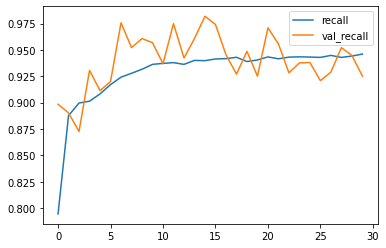

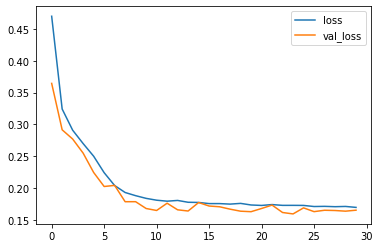

In [ ]:
model_1_func_history_df[['recall', 'val_recall']].plot()
model_1_func_history_df[['loss', 'val_loss']].plot();

In [ ]:
y_hat_1_func = model_1_func.predict(X_test_transformed)
y_hat_1_func = np.where(y_hat_1_func >= 0.5, 1, 0)

print(classification_report(y_test, y_hat_1_func))

174/174 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      2604
           1       0.94      0.92      0.93      2948

    accuracy                           0.93      5552
   macro avg       0.92      0.93      0.93      5552
weighted avg       0.93      0.93      0.93      5552



# Model Improvement

## Model 2

### Sequential

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model_2_seq = Sequential()
model_2_seq.add(Dense(80, activation='relu', input_shape=(5,)))
model_2_seq.add(Dense(80, activation='relu'))
model_2_seq.add(tf.keras.layers.Dropout(0.15))
model_2_seq.add(Dense(5, activation='relu'))
model_2_seq.add(tf.keras.layers.Dropout(0.15))
model_2_seq.add(Dense(1, activation='sigmoid'))

model_2_seq.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.01), metrics=[tf.keras.metrics.Recall()])

model_2_seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                480       
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 405       
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 7,371
Trainable params: 7,371
Non-trainabl

Dari model 1 sequential kita melakukan pengembangan dengan menambahkan layer dropout setelah hidden layer kedua dan ketiga sebelum output.
Kita juga mengubah learning optimizer Adam dari defaultnya 0.001 ke 0.01.

In [ ]:
%%time
model_2_seq_history = model_2_seq.fit(X_train_transformed, y_train, epochs=30, validation_data=(X_val_transformed, y_val), batch_size=10, verbose=0)

CPU times: user 3min 9s, sys: 10.7 s, total: 3min 20s
Wall time: 2min 44s


In [ ]:
model_2_seq_history_df = pd.DataFrame(model_2_seq_history.history)
model_2_seq_history_df

,loss,recall,val_loss,val_recall
0,0.424016,0.893037,0.234579,0.941984
1,0.279778,0.956195,0.232272,0.943552
2,0.257857,0.952476,0.193541,0.918855
3,0.248494,0.951236,0.201997,0.976872
4,0.244590,0.950479,0.169049,0.949432
5,0.241762,0.937943,0.186829,0.909055
6,0.240795,0.938632,0.256414,0.965896
7,0.234534,0.943867,0.177492,0.978048
8,0.230612,0.939872,0.190800,0.932575
9,0.221138,0.953303,0.168105,0.951784


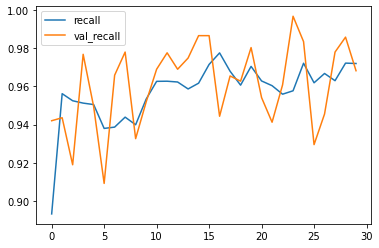

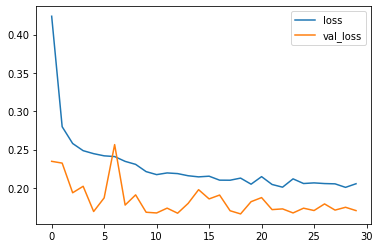

In [ ]:
model_2_seq_history_df[['recall', 'val_recall']].plot()
model_2_seq_history_df[['loss', 'val_loss']].plot();

Recall pada saat training tidak berbeda jauh dengan recall saat melakukan validation, yang mana hal ini bisa menunjukkan bahwa model kita good fit.

In [ ]:
y_hat_2_seq = model_2_seq.predict(X_test_transformed)
y_hat_2_seq = np.where(y_hat_2_seq >= 0.5, 1, 0)

print(classification_report(y_test, y_hat_2_seq))

174/174 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.96      0.85      0.90      2604
           1       0.88      0.97      0.92      2948

    accuracy                           0.91      5552
   macro avg       0.92      0.91      0.91      5552
weighted avg       0.91      0.91      0.91      5552



Model 2 sequential menghasilkan recall score yang lebih besar dari model 1 sequential, yang mana hal ini memang yang kita inginkan. Kita ingin memiliki recall score yang besar namun precision yang tidak kecil, yang mana model 2 sequential mendapatkan precison lebih dari 80%.  

Dengan recall yang lebih baik dari model 1, kita dapat menggunakan model 2 sequential untuk menghindari customers kita churn dengan lebih baik. Kita dapat memprediksi bahwa beberapa customer kita akan churn, lalu kita bisa melakukan komunikasi dengan mereka melalui email, text, dll, dan menawarkan diskon, layanan yang lebih baik dan lainnya untuk memperlambat niat mereka untuk churn atau lebih baik lagi menjadikan mereka customer yang puas dengan layanan dan produk kita.   

Walaupun dengan prediksi customer churn yang baik (recall tinggi, False Negative kecil), kita juga akan mengirimkan email, text mengenai diskon tersebut kepada beberapa customer yang tidak berisiko churn. Namun, karena precision kita masih besar, yaitu di atas 80%, kita akan mengirimkan diskon kepada hanya sedikit customer yang tidak berisiko churn (False Positive).

### Functional

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

input_layer = Input(shape=(5,))
hiddenlayer_1 = Dense(80, activation='relu')(input_layer)
hiddenlayer_2 = Dense(80, activation='relu')(hiddenlayer_1)
hiddenlayer_3 = Dense(80, activation='relu')(hiddenlayer_2)
hiddenlayer_4 = Dense(2, activation='relu')(hiddenlayer_3)

concat_layer = concatenate([hiddenlayer_1, hiddenlayer_4])
output_layer = Dense(1, activation='sigmoid')(concat_layer)

model_2_func = Model(inputs=input_layer, outputs=output_layer)

model_2_func.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[tf.keras.metrics.Recall()])
model_2_func.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 80)           480         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 80)           6480        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 80)           6480        ['dense_1[0][0]']                
                                                                                              

Pada model 2 functional, kita melakukan beberapa pengembangan dari model functional versi 1 yaitu:  
1. Neuron pada hidden layer 1 dan hidden layer 2 diperbanyak
2. Menambahkan dua hidden layer lagi
3. Melakukan concat hidden layer 1 dan hidden layer 4
4. Merubah learning rate optimizer Adam dari 0.001 ke 0.01

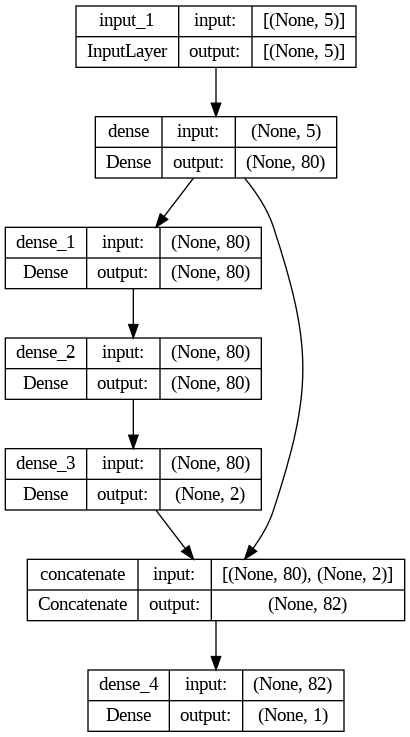

In [ ]:
tf.keras.utils.plot_model(model_2_func, show_shapes=True)

In [ ]:
%%time
model_2_func_history = model_2_func.fit(X_train_transformed, y_train, epochs=30, validation_data=(X_val_transformed, y_val), batch_size=10, verbose=0)

CPU times: user 4min 2s, sys: 13.9 s, total: 4min 16s
Wall time: 4min 22s


In [ ]:
model_2_func_history_df = pd.DataFrame(model_2_func_history.history)
model_2_func_history_df

,loss,recall,val_loss,val_recall
0,0.402748,0.843860,0.305294,0.892199
1,0.295557,0.895447,0.239593,0.933751
2,0.252133,0.917694,0.399014,0.800470
3,0.235415,0.924375,0.210731,0.970600
4,0.228866,0.926235,0.204808,0.932967
5,0.223465,0.930160,0.264515,0.855743
6,0.220120,0.929541,0.188533,0.963936
7,0.217931,0.930160,0.204214,0.953744
8,0.221648,0.929127,0.221278,0.961584
9,0.217565,0.931882,0.192811,0.923951


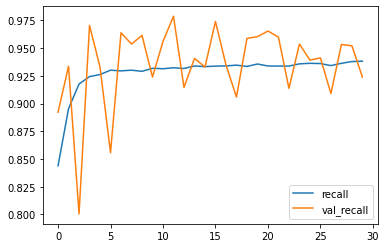

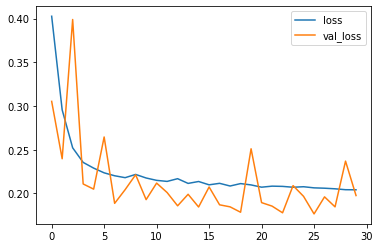

In [ ]:
model_2_func_history_df[['recall', 'val_recall']].plot()
model_2_func_history_df[['loss', 'val_loss']].plot();

In [ ]:
y_hat_2_func = model_2_func.predict(X_test_transformed)
y_hat_2_func = np.where(y_hat_2_func >= 0.5, 1, 0)

print(classification_report(y_test, y_hat_2_func))

174/174 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      2604
           1       0.92      0.93      0.92      2948

    accuracy                           0.92      5552
   macro avg       0.92      0.91      0.91      5552
weighted avg       0.92      0.92      0.92      5552



Model 2 functional mengalami perkembangan pada recall scorenya namun scorenya hampir sama dengan model 1 functional, yaitu pada model 2 functional recall score mengalamai kenaikan hanya 1 point atau percent dari model 1 saat penulis jalankan.

Dengan recall score yang mengalami kenaikan hanya sedikit, kita tidak dapat melakukan prediksi customer yang beneran akan churn dengan lebih baik secara signifikan. 

**Model terbaik dari model improvement adalah model sequential yang mendapatkan recall score 97% (model_2_seq).**  
Model ini selanjutnya akan kita pakai sebagai model untuk melakukan inference dan akan kita deploy.

## Kelebihan dan kelemahan model

Kelebihan:  
1. Model dapat perform dengan stabil pada training dataset
2. Model bisa dibilang good fit walaupun perform secara tidak stabil pada validation dataset   

Kelemahan:  
1. Model memiliki performance tidak stabil pada validation dataset
2. Model training masih bisa dibilang lama dengan epoch = 30
3. Jika model dirun ulang, model dapat memberikan performance score yang berbeda.

## Model improvements yang dapat dilakukan selanjutnya

1. Lebih memahami dropout layer agar model dapat perform dengan stabil pada validation dataset
2. Ukuran validation dataset bisa lebih dibesarkan untuk mengurangi performa yang tidak stabil
3. menggunakan earlystopping
4. menggunakan threshold dari callback tensorflow bukan np.where

# Model Inference (Saving)

In [ ]:
with open('pipe_infer.pkl', 'wb') as file_1:
  pickle.dump(pipe_preprocessing_best, file_1)

In [ ]:
model_2_seq.trainable = False

In [ ]:
model_2_seq.save('model_infer.h5')

# Overall Analysis (Kesimpulan)

Pada proses EDA, kita bisa berasumsi bahwa jumlah uang yang dihabiskan untuk membeli produk kita, points yang mereka punya, frekuensi login ke website, jenis membership, dan feedback yang mereka berikan dapat melakukan klasifikasi customer kita menjadi customer yang churn dan yang tidak churn.  

Lima features di atas terbukti penting untuk melakukan klasifikasi customer kita akan churn atau tidak setelah kita melakukan features selection. Dari sekian numerical features, jumlah uang yang dihabiskan, points yang mereka dapatkan, frekuensi login ke website adalah tiga features teratas yang mendapatkan score Anova F-value tertinggi. Lalu dari sekian banyak categorical features, jenis membership dan feedback adalah dua features yang mendapatkan score chi2 tertinggi.  

Dari lima features tersebut, kita mendapatkan recall score yang paling bagus.   

Setelah melakukan perkembangan dari model 1 sequential ke model 2 sequential dan dari model 1 functional ke model 2 functional, kita dapat melihat bahwa case kita dapat melakukan prediksi customer churn membutuhkan layer yang lumayan banyak dan learning rate yang lebih kecil dari defaultnya.  

Namun performa pada validation set yang tidak stabil belum bisa diperbaiki dengan menambahkan dropout layer pada sequntial model dan concat layer, juga learning rate pada functional model. Objective kita selanjutnya termasuk memperbaiki performa yang tidak stabil pada validation set.  

Dari dua model improvement yang sudah dilakukan, model sequential masih lebih bagus dibandingkan model functional. Model 2 sequential mendapatkan recall score yang lebih tinggi dari model 2 functional dan model 2 sequential juga dapat perform lebih stabil pada validation set dibandingkan model 2 functional.   

Maka dari itu, kita memilih model 2 sequential sebagai model yang akan kita gunakan pada day-to-day business untuk melakukan klasifikasi apakah customer kita akan churn atau tidak. Model ini akan membantu kita untuk mengurangi customer kita akan churn dengan melakukan prediksi terlebih dahulu apakah ada customer yang kemungkinan akan churn, kemudian kita akan memberikan customer-customer tersebut diskon, gift, layanan special, dll melalui email dan lainnya untuk membuat customer-customer tersebut mengurungkan niat mereka untuk churn.

# Rekomendasi Bisnis

1. Dengan kita sudah mendapatkan model yang dapat bekerja dengan baik untuk day-to-day business kita, kita dapat melakukan antisipasi customer churn lebih awal. Namun sebagiknya kita juga menyesuaikan dengan apa yang customer tidak suka dari kita.  

2. Jika customers memberikan feedback yang spesifik seperti iklan yang muncul di website terlalu banyak, kita dapat melakukan penghapusan beberapa iklan khusus untuk customer tersebut. Penghapusan beberapa iklan ini tentu tidak ingin kita lakukan kepada customer yang tidak mengeluhkan hal itu.  

3. Jika alasan dari customer akan churn adalah karena membership mereka masih basic, kita bisa memberikan diskon berapa bulan untuk membership tententu khusus customer tersebut. Hal ini juga tidak mau kita lakukan kepada customer yang tidak beralasan seperti itu.  

4. Kita juga bisa melakukan clustering customer yang akan churn agar kita tidak memberikan solusi dengan terlalu spesifik yang bisa saja dapat merugikan kita.